# 自编码示例

In [1]:
import warnings
import cv2
import keras
import numpy as np
import tensorflow as tf

from PIL import Image
from keras.datasets import mnist
from keras import layers

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from matplotlib import pyplot as plt

In [3]:
# 加载 MNIST 数据
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    train, test = [list(i) for i in mnist.load_data()]

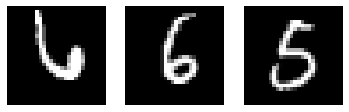

In [4]:
# 显示图片
index = np.random.randint(train[0].shape[0], size=3)
fig, ax = plt.subplots(ncols=index.shape[0])
for i in range(index.shape[0]):
    ax[i].set_axis_off()
    ax[i].imshow(train[0][index[i]], cmap="gray")
    
plt.show()

# 数据处理
图像像素值范围 $[0,255]$，在模型搭建过程中避免某些数据值过大导致其他信息被屏蔽，因此先将数据缩放——缩放的方式为 MinMax 方式

In [5]:
# 缩放数据
train[0] = train[0] / 255
test[0] = test[0] / 255

In [6]:
# 拆分数据
validate = (train[0][:int(train[0].shape[0] * .2)], train[1][:int(train[0].shape[0] * .2)])
train = (train[0][int(train[0].shape[0] * .2):], train[1][int(train[0].shape[0] * .2):])

# 搭建模型

In [7]:
# 构建新的评估指标
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [8]:
class AutoEncoder:
    def __init__(self, img_size=(28, 28)):
        # encoder node
        encoder_input_ = layers.Input(shape=img_size, name="encoder_input")
        flatten = layers.Flatten(name="encoder_flatten")(encoder_input_)
        encoder_output_ = layers.Dense(name="encoder_output", units=64, activation="relu")(flatten)
        
        self.encoder = keras.Model(encoder_input_, encoder_output_, name="encoder")
        
        # decoder node
        decoder_input_ = layers.Dense(name="decoder_input", units=64, activation="relu")(encoder_output_)
        dense = layers.Dense(name="decoder_dense", units=np.prod(img_size), activation="relu")(decoder_input_)
        decoder_output_ = layers.Reshape(target_shape=img_size, name="decoder_output")(dense)
        
        # optimizer
        self.optimizer = keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)
        
        # combine two nodes
        self.model = keras.Model(encoder_input_, decoder_output_, name="auto_encoder_model")
    
    def summary(self):
        """Diplay Model Summary"""
        return self.model.summary()
    
    def compile(self, **kwargs):
        """Compile Model"""
        if "optimizer" not in kwargs:
            kwargs["optimizer"] = self.optimizer
        return self.model.compile(**kwargs)
    
    def fit(self, x, y, **kwargs):
        """Train Model"""
        self.model.fit(x, y, **kwargs)

In [9]:
# Train model
model = AutoEncoder()
model.compile(loss=["mse"])
model.fit(train[0], train[0], epochs=10, validation_data=(validate[0], validate[0]))

Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0343 - val_loss: 0.0160
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0155 - val_loss: 0.0143
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 8/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.012

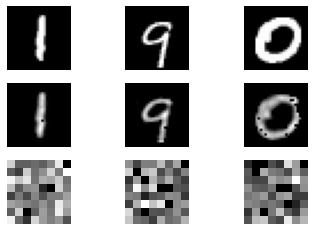

In [10]:
index = np.random.randint(test[0].shape[0], size=3)
fig, ax = plt.subplots(nrows=3, ncols=index.shape[0])
for col in range(index.shape[0]):
    for row in range(3):
        ax[row][col].set_axis_off()
    ax[0][col].imshow(test[0][index[col]], cmap="gray")
    ax[1][col].imshow(model.model.predict(test[0])[index[col]], cmap="gray")
    ax[2][col].imshow(model.encoder.predict(test[0])[index[col]].reshape((8,8)), cmap="gray")
plt.show()

上图三行分别表示：
* 第一行为原始图片信息
* 第二行为预测的图片信息
* 第三行为 encoder 结果的特征信息